---

In [2]:
%load_ext lab_black

In [18]:
import math
import os
import random
import shutil
import json
import logging
import sys
from collections import defaultdict
from datetime import datetime
from io import TextIOWrapper
from pathlib import Path
from typing import Callable, List, Sequence, Tuple
from dataclasses import dataclass

import albumentations as A
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from tqdm import tqdm
from PIL import Image

import utils
import networks

---

## 하이퍼 파라미터

In [4]:
RESULT_DIR = Path("results/det")

DET_MODEL = "EfficientDet-d4"
LR = 1e-4  # transfer learning이니깐 좀 작게 주는게 좋을 것 같아서 1e-4
BATCH_SIZE = 2
START_EPOCH = 1
SAM = False
FOLD = 1
PADDING = 30

n = datetime.now()
UID = f"{n.year:04d}{n.month:02d}{n.day:02d}-{n.hour:02d}{n.minute:02d}{n.second:02d}"
SEED = 20210309

In [6]:
utils.seed_everything(SEED, deterministic=False)
RESULT_DIR.mkdir(parents=True, exist_ok=True)
log = utils.CustomLogger(RESULT_DIR / f"log_{UID}.log", "a")
log.info("학습 시작")
log.info("DET_MODEL:", DET_MODEL)
log.info("UID:", UID)
log.info("SEED:", SEED)
log.info("LR:", LR)
log.info("BATCH_SIZE:", BATCH_SIZE)
log.info("START_EPOCH:", START_EPOCH)
log.info("SAM:", SAM)
log.info("FOLD:", FOLD)
log.info("PADDING:", PADDING)
log.flush()

[2021-03-11 15:57:35  INFO] 학습 시작
[2021-03-11 15:57:35  INFO] UID: 20210311-155735
[2021-03-11 15:57:35  INFO] SEED: 20210309
[2021-03-11 15:57:35  INFO] LR: 0.0001
[2021-03-11 15:57:35  INFO] BATCH_SIZE: 10
[2021-03-11 15:57:35  INFO] START_EPOCH: 1
[2021-03-11 15:57:35  INFO] SAM: False
[2021-03-11 15:57:35  INFO] FOLD: 1
[2021-03-11 15:57:35  INFO] HRNET_WIDTH: 48
[2021-03-11 15:57:35  INFO] AUG_HORIZONTAL_FLIP: True
[2021-03-11 15:57:35  INFO] AUG_SHIFT: False


---

## 데이터 로딩

In [107]:
total_imgs = np.array(sorted(list(Path("data/ori/train_imgs/").glob("*.jpg"))))
test_imgs = np.array(sorted(list(Path("data/ori/test_imgs/").glob("*.jpg"))))

df = pd.read_csv("data/ori/train_df.csv")
total_keypoints = df.to_numpy()[:, 1:].astype(np.float32)
total_keypoints = np.stack([total_keypoints[:, 0::2], total_keypoints[:, 1::2]], axis=2)

In [114]:
def keypoint2box(keypoint, padding=0):
    return np.array(
        [
            keypoint[:, 0].min() - padding,
            keypoint[:, 1].min() - padding,
            keypoint[:, 0].max() + padding,
            keypoint[:, 1].max() + padding,
        ]
    )

### 패딩을 얼마나 줘야할지 확인

In [115]:
img = imageio.imread(train_imgs[0])

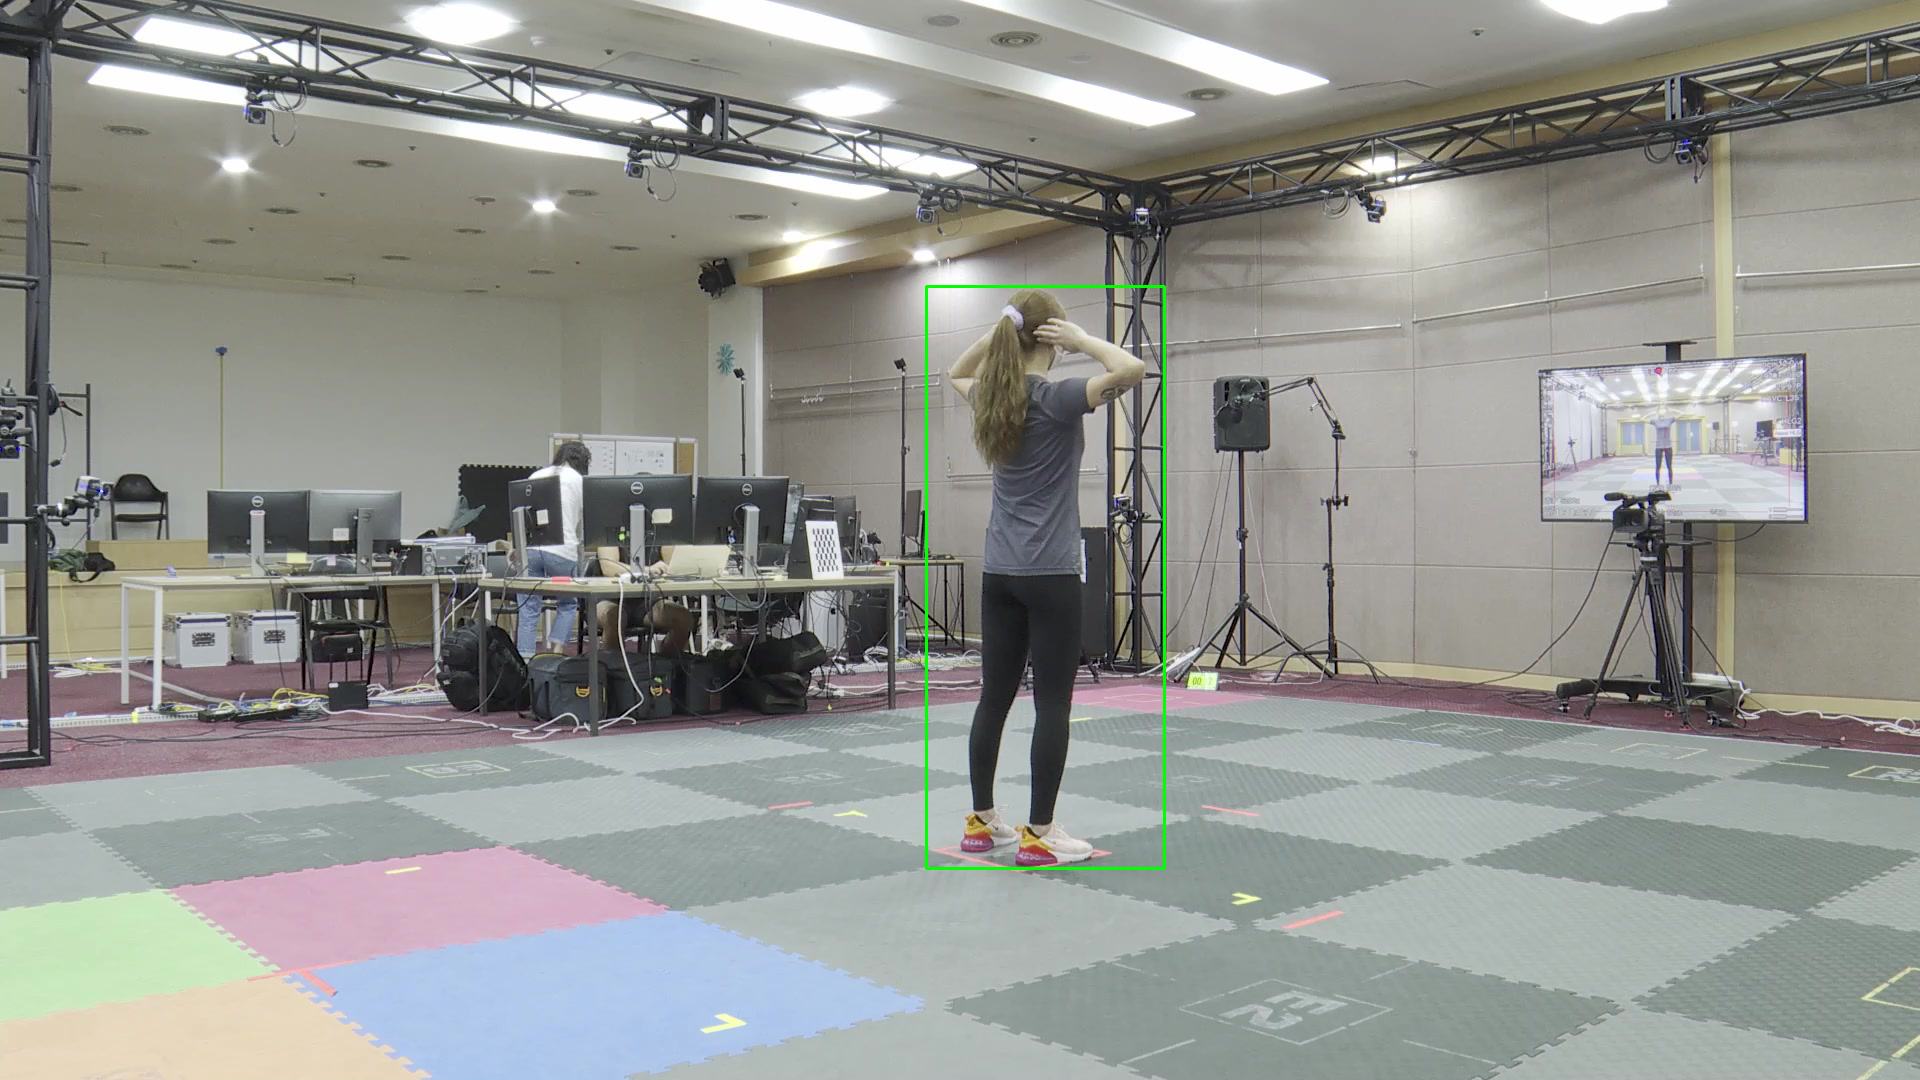

In [116]:
box = keypoint2box(total_keypoints[0], 30).astype(np.int64)
Image.fromarray(cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2))

### TODO

#### rotation에서 interpolation은 constant 0으로 하는게 좋을듯

#### 무조건 rotation or scale or shift 되도록 한 다음에 

#### HRNet에서 사용하는 loss

#### HRNet에서 detection된거를 어떻게 HRNet의 입력으로 주는지

#### 쓰는거는 서로 함께 쓰더라도 학습은 따로하는게 좋지 않을지?

메모리 문제도 있고, 코드가 너무 복잡해질 것 같음

In [117]:
class DetectionDataset(Dataset):
    def __init__(self, files, keypoints=None, augmentation=True, padding=30):
        super().__init__()
        self.files = files
        self.keypoints = keypoints
        self.padding = padding

        T = []
        T.append(A.Crop(256, 28, 1920 - 256, 1080 - 28))  # 1920x1080 --> 1920x1024
        if augmentation:
            T.append(A.ImageCompression())
            T.append(A.ShiftScaleRotate(border_mode=cv2.BORDER_CONSTANT, value=0, rotate_limit=0))
            T.append(A.HorizontalFlip())
            T.append(A.Cutout())
            T_ = []
            T_.append(A.RandomBrightnessContrast())
            T_.append(A.RandomGamma())
            T_.append(A.RandomBrightness())
            T_.append(A.RandomContrast())
            T.append(A.OneOf(T_))
            T.append(A.GaussNoise())
            T.append(A.Blur())
        T.append(A.Normalize())
        T.append(ToTensorV2())

        if self.keypoints is not None:
            self.transform = A.Compose(T, bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]))
        else:
            self.transform = A.Compose(T)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        image = imageio.imread(self.files[idx])

        if self.keypoints is not None:
            box = keypoint2box(self.keypoints[idx], self.padding)
            box = np.expand_dims(box, 0)
            labels = np.array([0], dtype=np.int64)
            a = self.transform(image=image, labels=labels, bboxes=box)

            # Image
            image = a["image"]

            # Annotation
            annot = np.zeros((1, 5), dtype=np.float32)
            annot[0, :4] = a["bboxes"][0]
            annot[0, 4] = 0
            annot = torch.tensor(annot, dtype=torch.float32)

            return image, annot
        else:
            a = self.transform(image=image)
            return a["image"]

In [131]:
kf = KFold(shuffle=True, random_state=SEED)
train_idx, valid_idx = list(kf.split(total_imgs))[FOLD - 1]
train_imgs, valid_imgs = total_imgs[train_idx], total_imgs[valid_idx]
train_keypoints, valid_keypoints = total_keypoints[train_idx], total_keypoints[valid_idx]
ds_train = DetectionDataset(train_imgs, train_keypoints, augmentation=True, padding=PADDING)
ds_valid = DetectionDataset(valid_imgs, valid_keypoints, augmentation=False, padding=PADDING)

In [132]:
len(ds_train), len(ds_valid)

(3356, 839)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


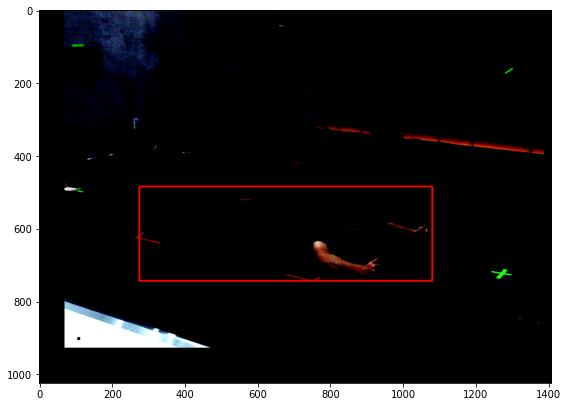

In [153]:
img, annot = ds_train[3000]
plt.figure(figsize=(8, 8))
img = img.permute(1, 2, 0).numpy()
cv2.rectangle(img, (annot[0, 0], annot[0, 1]), (annot[0, 2], annot[0, 3]), (255, 0, 0), 3)
plt.imshow(img)
plt.tight_layout()
plt.show()

---

## 학습 모델 준비

In [154]:
@dataclass
class TrainOutputBean:
    loss = utils.AverageMeter()

    def freeze(self):
        self.loss = self.loss()


class TrainInputBean:
    def __init__(self):
        self.det_model = networks.EfficientDet("efficientdet-d4", pretrained=True).cuda()
        if SAM:
            self.optimizer = utils.SAM(self.det_model.parameters(), optim.AdamW, lr=LR)
        else:
            self.optimizer = optim.AdamW(self.det_model.parameters(), lr=LR)
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.5, patience=4, verbose=True)

        self.epoch = START_EPOCH

In [155]:
def train_loop(B: TrainInputBean, dl: DataLoader):
    torch.cuda.empty_cache()
    B.det_model.train()

    O = TrainOutputBean()
    with tqdm(total=len(dl.dataset), ncols=100, leave=False, file=sys.stdout, desc=f"Train[{B.epoch:03d}]") as t:
        for imgs, annots in dl:
            imgs_, annots_ = imgs.cuda(), annots.cuda()
            loss = B.det_model(imgs_, annots_)

            B.optimizer.zero_grad()
            loss.backward()
            if isinstance(B.optimizer, utils.SAM):
                B.optimizer.first_step()
                B.det_model(imgs_, annots_).backward()
                B.optimizer.second_step()
            else:
                B.optimizer.step()

            O.loss.update(loss.item())
            t.set_postfix_str(f"loss: {loss.item():.6f}", refresh=False)
            t.update(len(imgs))

    return O

In [156]:
@torch.no_grad()
def valid_loop(B: TrainInputBean, dl: DataLoader):
    torch.cuda.empty_cache()
    B.det_model.eval()

    O = TrainOutputBean()
    with tqdm(total=len(dl.dataset), ncols=100, leave=False, file=sys.stdout, desc=f"Valid[{B.epoch:03d}]") as t:
        for imgs, annots in dl:
            imgs_, annots_ = imgs.cuda(), annots.cuda()
            loss = B.det_model(imgs_, annots_)

            O.loss.update(loss.item())
            t.set_postfix_str(f"loss: {loss.item():.6f}", refresh=False)
            t.update(len(imgs))

    return O

---

## 학습

In [ ]:
kf = KFold(shuffle=True, random_state=SEED)
train_idx, valid_idx = list(kf.split(total_imgs))[FOLD - 1]
train_imgs, valid_imgs = total_imgs[train_idx], total_imgs[valid_idx]
train_keypoints, valid_keypoints = total_keypoints[train_idx], total_keypoints[valid_idx]
ds_train = DetectionDataset(train_imgs, train_keypoints, augmentation=True, padding=PADDING)
ds_valid = DetectionDataset(valid_imgs, valid_keypoints, augmentation=False, padding=PADDING)
dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, num_workers=8, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, num_workers=8, shuffle=False)

In [ ]:
best_loss = math.inf
early_stop_cnt = 0
for epoch in range(START_EPOCH, 100):
    B = TrainInputBean()
    to = train_loop(B, dl_train)
    vo = valid_loop(B, dl_valid)

    # Logging
    log.info(f"Epoch: {epoch:03d}, loss: {to.loss:.6f};{vo.loss:.6f}")
    B.scheduler.step(vo.loss)

    # Earlystop
    if vo.loss < best_loss:
        best_loss = vo.loss
        early_stop_cnt = 0

        torch.save(
            {
                "model": B.det_model.state_dict(),
                "optimizer": B.optimizer.state_dict(),
                "epoch": epoch,
            },
            RESULT_DIR / f"ckpt-{UID}_{FOLD}.pth",
        )
    elif early_stop_cnt >= 10:
        log.info(f"Stop training at epoch {epoch}.")
        break
    else:
        early_stop_cnt += 1